In [1]:
from jax import config
config.update('jax_enable_x64', True)

from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from uncprop.models.elliptic_pde.experiment import (
    PDEReplicate,
    summarize_status,
    load_rep,
    read_samp,
    samp_trace,
    samp_pair_plot,
    plot_surrogate_pred,
    estimate_mahalanobis_coverage,
    assemble_coverage_reps,
    compute_wasserstein_comparison,
    summarize_wasserstein_design_reps,
)

from uncprop.utils.plot import (
    set_plot_theme, 
    smart_subplots,
    plot_coverage_curve,
    plot_coverage_curve_reps,
)

colors = set_plot_theme()

experiment_name = 'pde_experiment'
base_dir = Path('/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates')
output_dir = base_dir / 'out' / 'final'
base_out_dir = base_dir / 'out'

key = jr.key(12343)

/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if not output_dir.exists():
    output_dir.mkdir()

summarize_status(base_out_dir, experiment_name, n_design=[10, 20, 30])

### Coverage plots

In [ ]:
ndesign = [10, 20, 30]
approx_dist_names = ['mean', 'eup', 'ep_mcwmh']
probs = jnp.linspace(0.1, 0.99, 10)

fig, axs = smart_subplots(nrows=3, ncols=3, flatten=False)

for n_idx, n in enumerate(ndesign):
    coverage_n = assemble_coverage_reps(base_out_dir, experiment_name, n_design=n, probs=probs, 
                                        approx_dist_names=approx_dist_names)

    for dist_idx, dist_name in enumerate(approx_dist_names):
        ax = axs[n_idx, dist_idx]
        dist_name = 'ep' if dist_name == 'ep_mcwmh' else dist_name
        plot_coverage_curve_reps(log_coverage=jnp.log(coverage_n)[:,[dist_idx],:], 
                                 probs=probs, 
                                 names=[dist_name],
                                 colors=colors,
                                 qmin=0.05,
                                 qmax=0.95,
                                 single_plot=True,
                                 ax=ax,
                                 alpha=0.2, max_cols=3)
        
        if n_idx == 0: # first row
            ax.set_title(dist_name, fontsize=ax.title.get_fontsize() * 1.8)
        if n_idx != (len(ndesign)-1): # all but final row
            ax.set_xlabel(None)
            # ax.set_xticklabels([])
        else:
            ax.set_xlabel('nominal', fontsize=ax.xaxis.label.get_size() * 1.8)
        if dist_idx != 0: # all but first column
            ax.set_ylabel(None)
            # ax.set_yticklabels([])
        else:
            ax.set_ylabel(f'actual (N = {n})', fontsize=ax.yaxis.label.get_size() * 1.8)

        ax.get_legend().remove()

fig.savefig(output_dir / 'pde_coverage.png', bbox_inches='tight')
display(fig)


### Wasserstein plot for EP approximation

In [ ]:
key, key_w2_seed = jr.split(key)
design_sizes = [30]
keys_w2 = jr.split(key_w2_seed, len(design_sizes))
w2_results = []
epsilons = []

for i, n in enumerate(design_sizes):
    print('n_design: ', n)
    w2_results_n, eps_n = summarize_wasserstein_design_reps(keys_w2[i], 
                                                            base_out_dir, 
                                                            experiment_name, 
                                                            n_design=n, 
                                                            rep_idcs=range(100))
    jnp.savez(output_dir / f'w2_ndesign_{n}_manual.npz', **w2_results_n)
    w2_results.append(w2_results_n)
    epsilons.append(eps_n)

n_design:  30
Rep  0
Rep  1
Rep  2
Rep  3
Rep  4
Rep  5
Rep  6
Rep  7
Rep  8
Rep  9
Rep  10
Rep  11
Rep  12
Rep  13
Rep  14
Rep  15
Rep  16
Rep  17
Rep  18
Rep  19
Rep  20
Rep  21
Rep  22
Rep  23
Rep  24
Rep  25
Rep  26
Rep  27
Rep  28
Rep  29
Rep  30
Rep  31
Rep  32
Rep  33
Rep  34
Rep  35
Rep  36
Rep  37
Rep  38
Rep  39
Rep  40
Rep  41
Rep  42
Rep  43
Rep  44
Rep  45
Rep  46
Rep  47
Rep  48
Rep  49
Failed rep: 49
[Errno 2] No such file or directory: '/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates/out/pde_experiment/n_design_30/rep49/rkpcn_samples.npz'
Rep  50
Rep  51
Rep  52
Rep  53
Rep  54
Rep  55
Rep  56
Rep  57
Rep  58
Rep  59
Rep  60
Rep  61
Rep  62
Rep  63
Rep  64
Rep  65
Rep  66
Rep  67
Rep  68
Rep  69
Rep  70
Rep  71
Rep  72
Rep  73
Rep  74
Rep  75
Rep  76
Rep  77
Rep  78
Rep  79
Rep  80
Rep  81
Rep  82
Rep  83
Rep  84
Rep  85
Rep  86
Rep  87
Rep  88
Rep  89
Rep  90
Rep  91
Rep  92
Rep  93
Rep  94
Rep  95
Rep  96
Rep  97
Rep  98
Rep  99


In [37]:
w2_10 = jnp.load(output_dir / 'w2_ndesign_10_manual.npz', allow_pickle=True)['arr_0'].item()
w2_20 = jnp.load(output_dir / 'w2_ndesign_20_manual.npz', allow_pickle=True)['arr_0'].item()
w2_30 = dict(jnp.load(output_dir / 'w2_ndesign_30_manual.npz'))

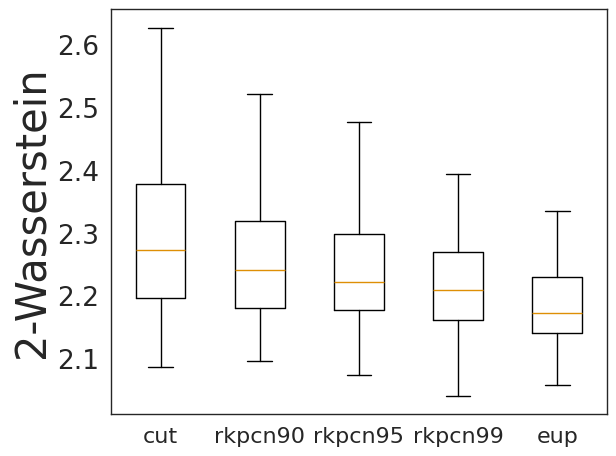

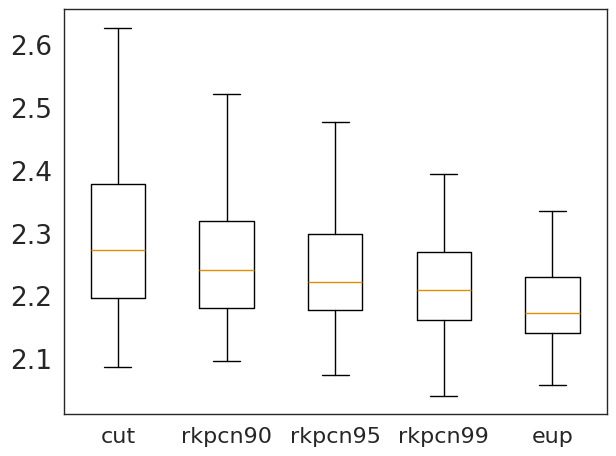

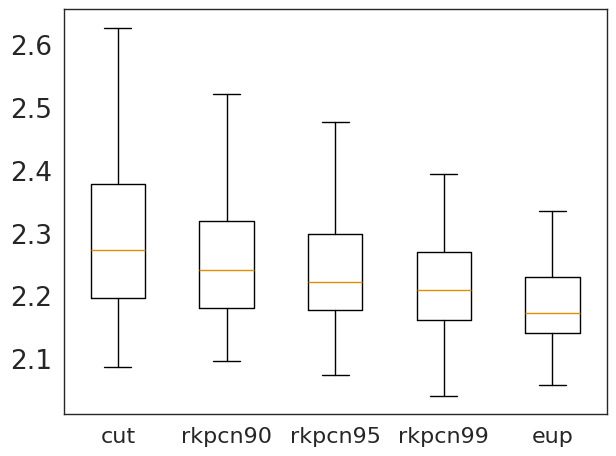

In [68]:
dist_names = ['cut', 'rkpcn90', 'rkpcn95', 'rkpcn99', 'eup']
w2_results = [w2_10, w2_20, w2_30]
n_design_vals = [10, 20, 30]

for n, w2_dict in zip(n_design_vals, w2_results):
    w2_dict = dict(w2_10)
    w2_dict['cut'] = w2_dict.pop('rkpcn0')
    w2_dict = {nm: w2_dict[nm] for nm in dist_names}

    plt.boxplot(list(w2_dict.values()), tick_labels=list(w2_dict.keys()), showfliers=False)
    
    if n == 10:
        plt.ylabel('2-Wasserstein', fontsize=30)
    else:
        plt.ylabel(None)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=19)

    plt.title('Distance Relative to Closed-Form EP')
    plt.title(None)
    plt.tight_layout()
    plt.savefig(output_dir / f'pde_w2_ndesign_{n}.png', dpi=300)
    plt.show()

In [ ]:
key = jr.key(142123)

key, key_w2 = jr.split(key)

dist_names = ['ep_mcwmh', 'eup', 'rkpcn0', 'rkpcn90', 'rkpcn95', 'rkpcn99', 'mean']

results, eps = compute_wasserstein_comparison(
    samples={k: samp[k] for k in dist_names},
    reference_key='ep_mcwmh',
    subsample=1000,
    key=key_w2,
    sinkhorn_kwargs={'threshold': 1e-6, 'max_iterations': 5000, 'lse_mode': True}
)

In [ ]:
results

### Investigate single replicate

In [ ]:
n_design = 10
rep_idx = 12

key = jr.key(63434)

rep = load_rep(base_out_dir, experiment_name, n_design, rep_idx)
samp = dict(read_samp(base_out_dir, experiment_name, n_design, rep_idx))

posterior = rep.posterior
posterior_surrogate = rep.posterior_surrogate

In [ ]:
from uncprop.models.elliptic_pde.experiment import sample_rkpcn

key, key_init_pos, key_rkpcn = jr.split(key, 3)
initial_position = posterior.prior.sample(key_init_pos).squeeze()

prop_cov = jnp.cov(samp['eup'], rowvar=False)

samp_rkpcn = sample_rkpcn(key=key_rkpcn,
                          posterior=posterior,
                          surrogate_post=posterior_surrogate,
                          initial_position=initial_position,
                          prop_cov=prop_cov,
                          rho=0.99,
                          n_samples=5_000,
                          n_burnin=50_000,
                          thin_window=5)
samp['rkpcn'] = samp_rkpcn

In [ ]:
for i in range(6):
    plt.plot(samp_rkpcn[:,i])
plt.show()

In [ ]:
import pandas as pd

key, key_prior = jr.split(key)
samp['prior'] = jr.normal(key_prior, samp['exact'].shape) # N(0, I) prior

dist_names = ['prior', 'ep_mcwmh', 'rkpcn']
par_names = [f'u{i}' for i in range(1, samp['exact'].shape[1]+1)]

df_list = []
for name in dist_names:
    df = pd.DataFrame(samp[name], columns=par_names)

    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
samp_trace(base_out_dir, experiment_name, n_design, rep_idx)

In [ ]:
samp_pair_plot(base_out_dir, experiment_name, 
               n_design=n_design, 
               rep_idx=rep_idx, dist_names=['prior', 'eup', 'exact'])

In [ ]:
samples = read_samp(base_out_dir, experiment_name, n_design, rep_idx)
probs = jnp.linspace(0.1, 0.99, num=10)

coverage = estimate_mahalanobis_coverage(samples=samples, 
                                         baseline='exact',
                                         probs=probs)

In [ ]:
log_coverage = jnp.log(jnp.stack([coverage[k] for k in coverage.keys()]))

fig_coverage, ax_coverage = plot_coverage_curve(log_coverage=log_coverage, 
                                                probs=probs, 
                                                names=list(coverage.keys()))

In [ ]:
plot_surrogate_pred(base_out_dir, experiment_name, 10, 1)

In [ ]:
from uncprop.core.distribution import DistributionFromDensity

observable_to_logdensity = posterior.likelihood.observable_to_logdensity
truncated_log_prior = DistributionFromDensity(log_dens=posterior.prior.log_density,
                                              dim=posterior.dim, support=posterior_surrogate.support)
truncated_log_prior_density = truncated_log_prior.log_density

def log_density(f, u):
    return observable_to_logdensity(f) + truncated_log_prior_density(u)

In [ ]:
from uncprop.core.samplers import mcmc_loop, init_rkpcn_kernel, _f_update_pcn_proposal
from typing import NamedTuple

key, key_init, key_init_pos, key_mcmc = jr.split(key, 4)

# settings for f update in sampler
class UpdateInfo(NamedTuple):
    rho: float
f_update_info = UpdateInfo(rho=0.99)

samp_exact = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')['exact']
prop_cov = jnp.cov(samp_exact, rowvar=False)

init_fn, kernel = init_rkpcn_kernel(key=key_init, 
                                    log_density=log_density,
                                    gp=posterior_surrogate.surrogate,
                                    f_update_fn=_f_update_pcn_proposal,
                                    f_update_info=f_update_info)

In [ ]:
key, key_init_state, key_step = jr.split(key, 3)

initial_state = init_fn(key=key_init_state,
                        initial_position=posterior.prior.sample(key_init_pos).squeeze(),
                        prop_cov=prop_cov)

newstate, _ = kernel(key_step, initial_state)        

In [ ]:
samp_exact = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')['exact']
prop_cov = jnp.cov(samp_exact, rowvar=False)

In [ ]:
samp = jnp.load(base_out_dir / experiment_name / f'n_design_{n_design}' / f'rep{rep_idx}' / 'samples.npz')
samp = dict(samp)
samp['rkpcn'] = samp_rkpcn